# Capstone : Default Risk Prediction Algorithm for Peer to Peer platform Investor

----------
## Contents:

## Model Evaluation & Conclusion 

1. [Importing Libraries](#1.-Importing-Libraries)
2. [Importing Data](#2.-Importing-Data)
3. [Data Cleaning](#3.-Data-Cleaning)
-------

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import pickle
from prettytable import PrettyTable
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
# sklearn: Import metrics.
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, \
                            accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve, average_precision_score, RocCurveDisplay, ConfusionMatrixDisplay

<u>Load training and test data</u>

In [59]:
model_train = pd.read_csv('./data/model_train.csv', index_col = 0, low_memory=False)
model_y_train = pd.read_csv('./data/model_y_train.csv', index_col = 0, low_memory=False)
model_test = pd.read_csv('./data/model_test.csv', index_col = 0, low_memory=False)
model_y_test = pd.read_csv('./data/model_y_test.csv', index_col = 0, low_memory=False)
org_coded_test = pd.read_csv('./data/org_coded_test.csv', index_col = 0, low_memory=False)
X_test = pd.read_csv('./data/x_test.csv', index_col = 0, low_memory=False)

<u>Load trained logistic regression model</u>

In [60]:
log_model = pd.read_pickle('./data/log_reg.pickle.dat')

<u>Test if model imported correctly:</u>

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


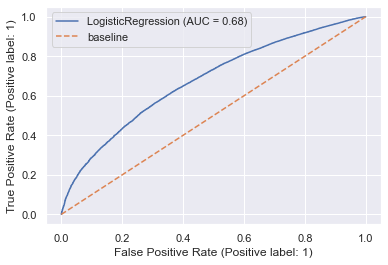

In [61]:
# from sklearn metrics
sns.set()
plot_roc_curve(log_model, model_test, model_y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--') # to simulate random guess 
plt.legend();

In [62]:
feature_name = model_train.columns.values
model_summary = pd.DataFrame(columns = ['feature_name'], data = feature_name)
model_summary['coefficients'] = np.transpose(log_model.coef_)
model_summary.index = model_summary.index + 1
model_summary.loc[0] = ['Intercept', log_model.intercept_[0]]
model_summary = model_summary.sort_index()
model_summary

,feature_name,coefficients
0,Intercept,-2.954975
1,grade:A,0.481915
2,grade:B,0.612104
3,grade:C,0.563314
4,grade:D,0.482458
5,grade:E,0.342655
6,grade:F,0.175369
7,home_ownership:OWN,0.156837
8,home_ownership:MORTGAGE,0.153143
9,verification_status:Not Verified,0.094583


## Creating an easily interpretable model for investor

In [63]:
ref_categories = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'term:60',
'dti:>35',
'int_rate:>20.281',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'delinq_2yrs:>=4',
'initial_list_status:f',
'emp_length:0',
'annual_inc:<20K']

<u>Note:</u>
To make the model interpretable to business investor, we have to put back the removed referenced dummy variable of each selected features which was dropped to avoid the dummy variable trap issue.

In [64]:
added_ref = pd.DataFrame(ref_categories, columns = ['feature_name'])
#as the reference categories aren't part of the features in the model, these would carry weights "zero" for interpretability
added_ref['coefficients'] = 0
added_ref

,feature_name,coefficients
0,grade:G,0
1,home_ownership:RENT_OTHER_NONE_ANY,0
2,verification_status:Verified,0
3,purpose:educ__sm_b__wedd__ren_en__mov__house,0
4,term:60,0
5,dti:>35,0
6,int_rate:>20.281,0
7,inq_last_6mths:>6,0
8,acc_now_delinq:0,0
9,delinq_2yrs:>=4,0


In [65]:
complete_model = pd.concat([model_summary, added_ref])
# Concatenates two dataframes.
complete_model = complete_model.reset_index()
# We reset the index of a dataframe.
complete_model

,index,feature_name,coefficients
0,0,Intercept,-2.954975
1,1,grade:A,0.481915
2,2,grade:B,0.612104
3,3,grade:C,0.563314
4,4,grade:D,0.482458
5,5,grade:E,0.342655
6,6,grade:F,0.175369
7,7,home_ownership:OWN,0.156837
8,8,home_ownership:MORTGAGE,0.153143
9,9,verification_status:Not Verified,0.094583


In [66]:
pd.set_option('display.max_rows', 500)
complete_model['org_feature_name'] = complete_model['feature_name'].str.split(':').str[0]
complete_model

,index,feature_name,coefficients,org_feature_name
0,0,Intercept,-2.954975,Intercept
1,1,grade:A,0.481915,grade
2,2,grade:B,0.612104,grade
3,3,grade:C,0.563314,grade
4,4,grade:D,0.482458,grade
5,5,grade:E,0.342655,grade
6,6,grade:F,0.175369,grade
7,7,home_ownership:OWN,0.156837,home_ownership
8,8,home_ownership:MORTGAGE,0.153143,home_ownership
9,9,verification_status:Not Verified,0.094583,verification_status


<u>Now, I want to scale the coefficients to a more business easy score</u>

In [67]:
lowest_score = 100
highest_score = 600

In [68]:
complete_model.groupby('org_feature_name')['coefficients'].min()

org_feature_name
Intercept             -2.954975
acc_now_delinq         0.000000
annual_inc            -0.021114
delinq_2yrs           -0.063012
dti                   -0.330107
emp_length             0.000000
grade                  0.000000
home_ownership         0.000000
initial_list_status    0.000000
inq_last_6mths         0.000000
int_rate               0.000000
purpose                0.000000
term                   0.000000
verification_status    0.000000
Name: coefficients, dtype: float64

In [69]:
min_possible_sum = complete_model.groupby('org_feature_name')['coefficients'].min().sum()
min_possible_sum

-3.3692078020181664

In [70]:
max_possible_sum = complete_model.groupby('org_feature_name')['coefficients'].max().sum()
max_possible_sum

2.3710771012204725

In [71]:
complete_model['score'] = complete_model['coefficients'] * (highest_score - lowest_score) / (max_possible_sum - min_possible_sum)
complete_model

,index,feature_name,coefficients,org_feature_name,score
0,0,Intercept,-2.954975,Intercept,-257.389195
1,1,grade:A,0.481915,grade,41.976558
2,2,grade:B,0.612104,grade,53.316522
3,3,grade:C,0.563314,grade,49.066720
4,4,grade:D,0.482458,grade,42.023878
5,5,grade:E,0.342655,grade,29.846505
6,6,grade:F,0.175369,grade,15.275293
7,7,home_ownership:OWN,0.156837,home_ownership,13.661047
8,8,home_ownership:MORTGAGE,0.153143,home_ownership,13.339340
9,9,verification_status:Not Verified,0.094583,verification_status,8.238519


In [72]:
min_possible_score = complete_model.groupby('org_feature_name')['score'].min().sum()
min_possible_score

-293.47043385575495

In [73]:
max_possible_score = complete_model.groupby('org_feature_name')['score'].max().sum()
max_possible_score

206.5295661442451

In [74]:
complete_model['score'][0] = ((complete_model['coefficients'][0] - min_possible_sum) / (max_possible_sum - min_possible_sum)) * (highest_score - lowest_score) + lowest_score
# We divide the difference of the value of the 'Coefficients' column and the minimum sum of coefficients by
# the difference of the maximum sum of coefficients and the minimum sum of coefficients.
# Then, we multiply that by the difference between the maximum score and the minimum score.
# Then, we add minimum score. 
complete_model


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,index,feature_name,coefficients,org_feature_name,score
0,0,Intercept,-2.954975,Intercept,136.081239
1,1,grade:A,0.481915,grade,41.976558
2,2,grade:B,0.612104,grade,53.316522
3,3,grade:C,0.563314,grade,49.066720
4,4,grade:D,0.482458,grade,42.023878
5,5,grade:E,0.342655,grade,29.846505
6,6,grade:F,0.175369,grade,15.275293
7,7,home_ownership:OWN,0.156837,home_ownership,13.661047
8,8,home_ownership:MORTGAGE,0.153143,home_ownership,13.339340
9,9,verification_status:Not Verified,0.094583,verification_status,8.238519


In [75]:
min_possible_score = complete_model.groupby('org_feature_name')['score'].min().sum()
min_possible_score

100.0

In [76]:
max_possible_score = complete_model.groupby('org_feature_name')['score'].max().sum()
max_possible_score

600.0

In [77]:
org_coded_test.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,home_ownership:MORTGAGE,...,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-150K,annual_inc:>150K
283311,0,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
328182,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
389681,0,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
223572,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
242106,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
model_test_score = org_coded_test

In [79]:
model_test_score.insert(0, 'Intercept', 1)

In [80]:
model_test_score.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,...,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-150K,annual_inc:>150K
283311,1,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
328182,1,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
389681,1,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
223572,1,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
242106,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
model_test_score = model_test_score[complete_model['feature_name'].values]
model_test_score

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,verification_status:Not Verified,...,purpose:educ__sm_b__wedd__ren_en__mov__house,term:60,dti:>35,int_rate:>20.281,inq_last_6mths:>6,acc_now_delinq:0,delinq_2yrs:>=4,initial_list_status:f,emp_length:0,annual_inc:<20K
283311,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,1,0
328182,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
389681,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
223572,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
242106,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8812,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
196086,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,1,0
232870,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,1,0
261076,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [82]:
credit_scorecard = complete_model['score']

In [83]:
model_test_score.shape

(93257, 65)

In [84]:
credit_scorecard.shape

(65,)

In [85]:
credit_scorecard = credit_scorecard.values.reshape(65, 1)

In [86]:
credit_scorecard.shape

(65, 1)

In [87]:
credit_scorecard

array([[136.08123879],
       [ 41.97655776],
       [ 53.31652239],
       [ 49.06672044],
       [ 42.02387804],
       [ 29.8465053 ],
       [ 15.27529319],
       [ 13.66104722],
       [ 13.33933993],
       [  8.23851919],
       [  8.38183611],
       [ 41.94026121],
       [ 31.60886509],
       [ 27.93551795],
       [ 34.47943472],
       [  6.69112841],
       [-16.45718979],
       [ -7.85504459],
       [ -2.23166824],
       [ -7.74873046],
       [-12.7864027 ],
       [-19.98905223],
       [-21.4786204 ],
       [-28.75352084],
       [-23.89604359],
       [131.77873043],
       [ 73.99655224],
       [ 43.08630039],
       [ 12.4411552 ],
       [110.47911465],
       [ 95.49875535],
       [ 74.50606029],
       [  2.10049508],
       [ -5.48858925],
       [ -3.02453579],
       [ 26.06643706],
       [  5.39968933],
       [  7.08423916],
       [  1.31977199],
       [  3.79924197],
       [ 10.223447  ],
       [ -1.8391287 ],
       [  5.00953321],
       [ 13

In [132]:
complete_model

,index,feature_name,coefficients,org_feature_name,score
0,0,Intercept,-2.954975,Intercept,136.081239
1,1,grade:A,0.481915,grade,41.976558
2,2,grade:B,0.612104,grade,53.316522
3,3,grade:C,0.563314,grade,49.066720
4,4,grade:D,0.482458,grade,42.023878
5,5,grade:E,0.342655,grade,29.846505
6,6,grade:F,0.175369,grade,15.275293
7,7,home_ownership:OWN,0.156837,home_ownership,13.661047
8,8,home_ownership:MORTGAGE,0.153143,home_ownership,13.339340
9,9,verification_status:Not Verified,0.094583,verification_status,8.238519


In [88]:
y_scores = model_test_score.dot(credit_scorecard)

In [89]:
y_scores.head()

,0
283311,418.666864
328182,400.106201
389681,424.182153
223572,354.194104
242106,320.272143


In [91]:
model_y_test.head()

,target
283311,1
328182,1
389681,1
223572,1
242106,0


In [94]:
scoring_dist = pd.concat([y_scores, model_y_test], axis=1)

In [95]:
scoring_dist.head()

,0,target
283311,418.666864,1
328182,400.106201,1
389681,424.182153,1
223572,354.194104,1
242106,320.272143,0


In [98]:
scoring_dist.rename(columns = {'O':'credit_score', 'target':'actual_state'}, inplace = True)

In [102]:
scoring_dist.rename(columns={scoring_dist.columns[0]: 'credit_score'}, inplace = True)

In [103]:
scoring_dist.head()

,credit_score,actual_state
283311,418.666864,1
328182,400.106201,1
389681,424.182153,1
223572,354.194104,1
242106,320.272143,0


<Figure size 3600x72 with 0 Axes>

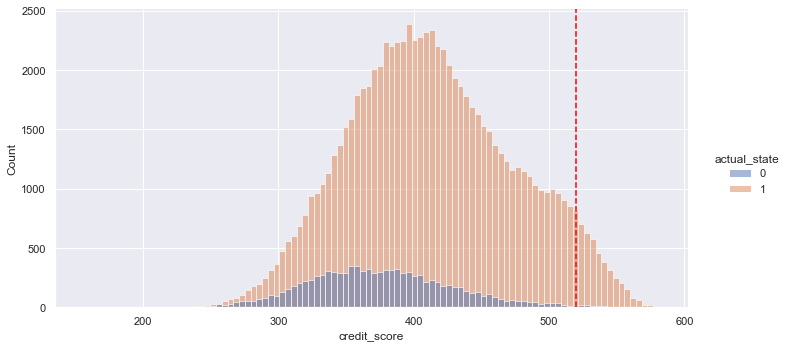

In [116]:
plt.figure(figsize = (50,1))
sns.displot(data=scoring_dist, x="credit_score", hue="actual_state", aspect=2, bins=100)
plt.axvline(520, color='red', ls='--')

In [119]:
X_test.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,next_pymnt_d,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,term_int,issue_d_date,issue_d_year,issue_d_month,emp_length_int,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Does not meet the credit policy. Status:Charged Off,loan_status:Does not meet the credit policy. Status:Fully Paid,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Late (16-30 days),loan_status:Late (31-120 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IA,addr_state:ID,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,home_ownership:RENT_OTHER_NONE_ANY,purpose:educ__sm_b__wedd__ren_en__mov__house,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,term:36,term:60,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,dti:>35,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,int_rate:>20.281,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,inq_last_6mths:>6,acc_now_delinq:0,acc_now_delinq:>=1,delinq_2yrs:0,delinq_2yrs:1-3,delinq_2yrs:>=4,emp_length:0,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,annual_inc:<20K,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-150K,annual_inc:>150K
283311,16000,36 months,11.67,528.92,B,B4,NaN,NaN,MORTGAGE,70000.0,Source Verified,Oct-14,Current,n,debt_consolidation,FL,24.06,0.0,2004-02-01,1.0,79.0,NaN,10.0,0.0,22191,69.1,29.0,f,Feb-16,79.0,0.0,0.0,231640.0,32100.0,36,2014-10-01,2014,2014-10,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
328182,20950,

In [120]:
scoring_dist.head()

,credit_score,actual_state
283311,418.666864,1
328182,400.106201,1
389681,424.182153,1
223572,354.194104,1
242106,320.272143,0


In [121]:
scoring_dist_int = pd.concat([X_test['int_rate'], scoring_dist], axis=1)

In [122]:
scoring_dist_int.head()

,int_rate,credit_score,actual_state
283311,11.67,418.666864,1
328182,10.99,400.106201,1
389681,11.67,424.182153,1
223572,15.31,354.194104,1
242106,17.86,320.272143,0


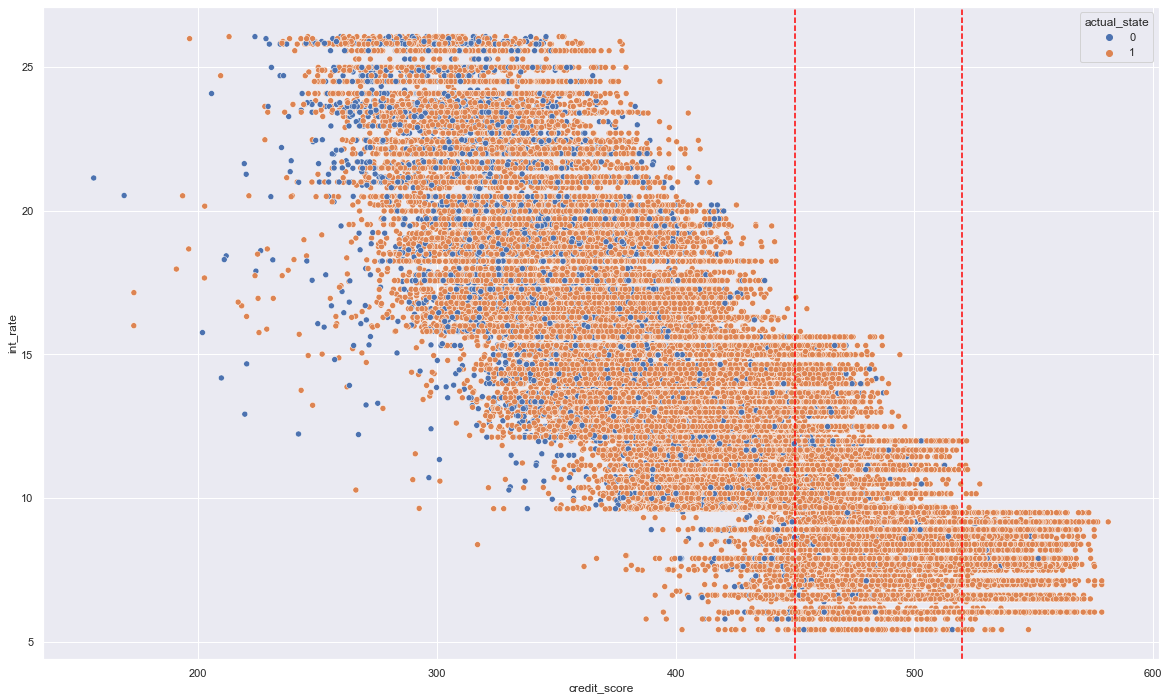

In [131]:
sns.set()
plt.figure(figsize = (20,12))
sns.scatterplot(data=scoring_dist_int, x="credit_score", y="int_rate", hue="actual_state")
plt.axvline(450, color='red', ls='--')
plt.axvline(520, color='red', ls='--')

<u>Observation:</u>

I am curious to see if there is any "serious mispricing of interest rate", for example charging high interest rate to highly credit worthy borrowers situation.  From the plot, we can a nice negative almost linear plot of the score against interest rates, with a higher concentration of high score borrower having interest rates of less than 10%.  To an investor leveraging on this tool, instead of choosing strictly borrower who has a score of more than 520, they can move into the range of 450 to 520 and the odds of funding a good borrower is still very high with potentially charging higher interest rate to this group.

## Conclusion & Future Work To Be Done

### <u>Conclusion:</u>

I have achieved most of the objective I have set out to do for this capstone project and with this credit scoring system (leveraging on existing financial industry practices), Lending Club investor has an additional risk assessment tool that enables them to compute a more granular score against potential borrower.  They can then leverage on this score to make a better decision to either fund (with an optimize interest rate) or reject the borrower if they aren't within the risk appetite of the investor.  This serve as an additional insight to the ranking score provided by Lending Club (Grade A to G) which is less granular.
For example, investor can choose a "cutoff score strategy" that suits their risk appetite like the one being taken which is illustrated in the diagram.  Investor can choose to be extremely conservative and accept only borrower with cutoff score of >520 to avoid any nasty delinquent or past due.  However, as you can see from the normal bell curve, fewer borrower will fall into this bucket who are extremely credit worthy and it also mean, only lower interest rate can be offered to the borrower.  To optimize the returns of investor, they can use the scoring tool to traverse down to a lower score to increase their risk appetite, at the same time, potentially improving their return (ability to charge higher interest rate).

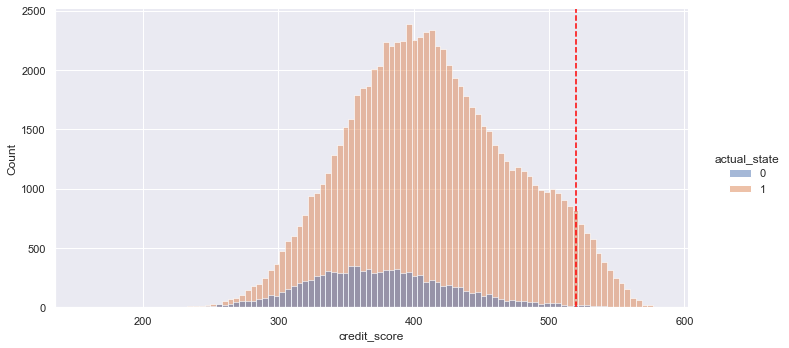

With this scoring system, investor can interpret the model easily in the form of a common scorecard and they can also interpret the model at the features or characteristic level.  For example, if the investor want to "loosen up" and accept borrower that has a lower range or bin of annual income, they know "how much decremental score (translated into risk)" they are exposing themselves to if they decide to fund the borrower.

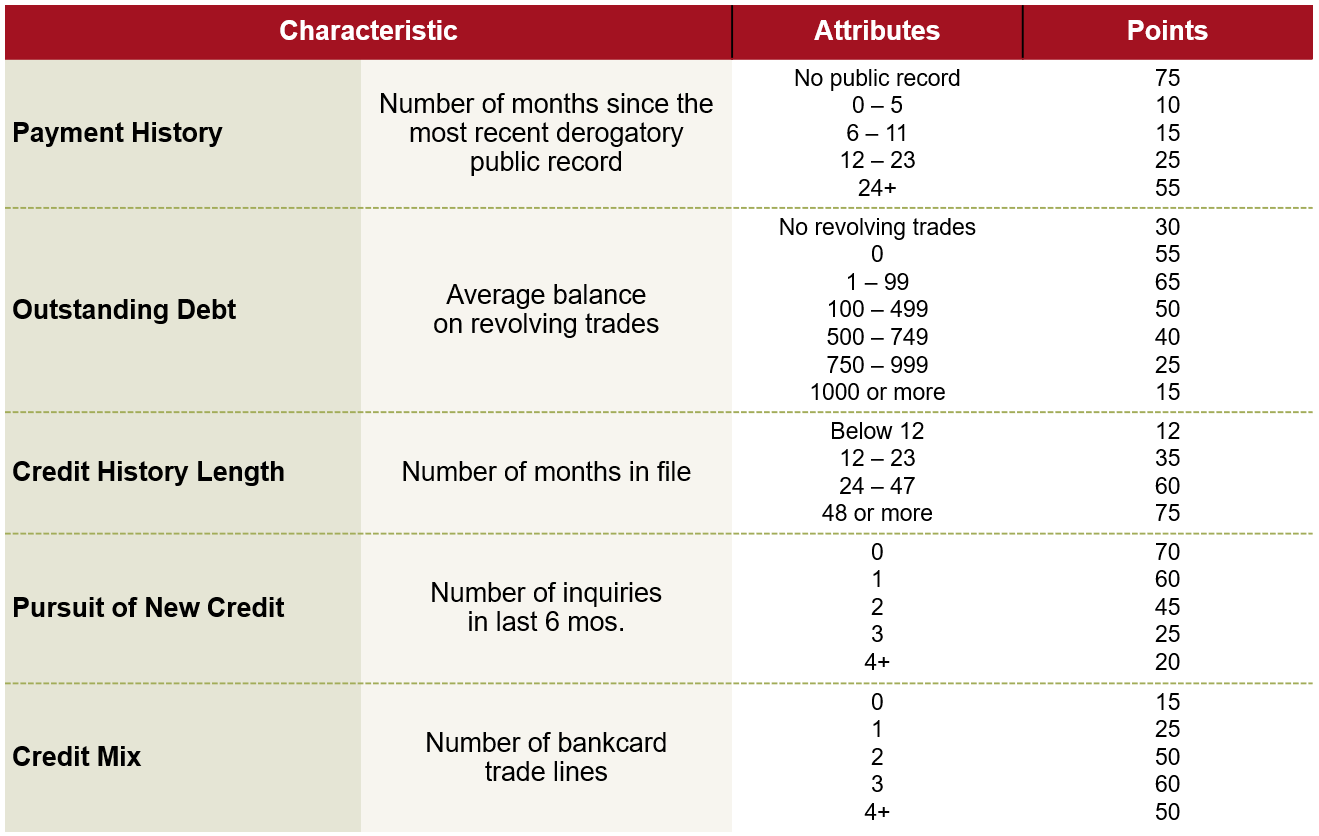

Although both academic and the technology industry have been actively doing and pursuing research in the domain of making AI or machine learning explainable and interpretable, I foresee it will take some time to come up with an alternative XAI approach which replace the existing scoring system widely used in the finance industry, especially regulatory related.
It is also good to understand why in certain financial domain, AI or machine learning technology are widely adopted like in the fraud problem domain.  They are not regulated per se and all loses subjected to fraudulent transaction are solely bank's or finanical institution exposure (hurt their own balance sheet).  Hence, in most cases, this area of application aren't subjected to the same level of scrutiny, as compared to credit assessment system.

### <u>Future Work:</u>

I will continue to expand further on this capstone project even after submission and these are the additional area of research I would like to continue:

1. There are usually 2 approaches in leveraging WOE, one is dummifying and creating the respective features bin which I have done in this project.  The other is to leverage directly the WOE values and use them like what similarly done with label encoding.
2. To automate the binning selection process and explore some interesting available package out there in the open source community
3. To use RenRen Dai dataset and perform similar approach to see how the methodology scale on a different dataset
4. To research further on explainable AI approach like, SHAP and LIME, to benchmark and compare further these tools against traditional scorecard approach presented

## Reference

<u>These are some useful reference which I have used:</u>

1. Weight of Evidence - https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html
2. Credit Scoring Introduction - https://www.amazon.com/Intelligent-Credit-Scoring-Implementing-Scorecards/dp/1119279151/ref=sr_1_4?crid=327LFO1YSF0AC&keywords=credit+scoring&qid=1649043614&s=books&sprefix=credit+scoring+%2Cstripbooks-intl-ship%2C333&sr=1-4
3. FICO Company - www.fico.com